In [1]:
# Core
import pandas as pd
import numpy as np
import os
import cv2
import gc
import re
import copy
import itertools
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob
import warnings
from IPython import display as ipd
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib.patches import Rectangle
import seaborn as sns
import random
from joblib import Parallel, delayed
import os, shutil
import datetime 
import holidays
import dateutil.easter as easter

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,SGDRegressor
from sklearn.model_selection import  GroupKFold,cross_val_score

from scipy.signal import savgol_filter


from matplotlib import pyplot
import missingno as msno
import plotly.express as px

import optuna

# Keras
import tensorflow as tf

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline

import lightgbm as lgb
from lightgbm import LGBMRegressor

# Keras
from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from tensorflow.keras.layers import LSTM, Flatten, TimeDistributed, Conv1D, Input, Dense, Multiply, Add, Activation, GRU, BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model, save_model, Sequential
from tensorflow.data import Dataset
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, Flatten,MaxPooling1D,BatchNormalization, Lambda, AveragePooling1D, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras as keras

# Import the Dataset

In [2]:
train_df = pd.read_csv('../input/tabular-playground-series-sep-2022/train.csv', parse_dates=['date'])
original_train_df = train_df.copy()
test_df = pd.read_csv('../input/tabular-playground-series-sep-2022/test.csv', parse_dates=['date'])
train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [3]:
df_gdp = pd.read_csv("../input/tpssep22-gdp-data-20172021/TPSSEP22_GDP_data_2017_to_2021.csv")
df_gdp_all = df_gdp.groupby('year')['GDP'].sum().reset_index()

In [4]:
for df in [train_df, test_df]:
    df['product'] = df['product'].str.replace(' ', '_')
    df['product'] = df['product'].str.replace(':', '_')

In [5]:
test_df.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle_Advanced_Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle_Getting_Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle_Recipe_Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle_for_Kids__One_Smart_Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle_Advanced_Techniques


# Explore the Dataset

In [6]:
train_df.isnull().sum()

row_id      0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [7]:
test_df.isnull().sum()

row_id     0
date       0
country    0
store      0
product    0
dtype: int64

In [8]:
print('\n  country in the train dataset\n')
print(train_df['country'].value_counts())

print('\n  country in the test dataset\n')
print(test_df['country'].value_counts())

print('\n store in the train dataset\n')
print(train_df['store'].value_counts())

print('\n store in the test dataset\n')
print(test_df['store'].value_counts())

print('\n product in the train dataset\n')
print(train_df['product'].value_counts())

print('\n product in the test dataset\n')
print(test_df['product'].value_counts())


  country in the train dataset

Belgium    11688
France     11688
Germany    11688
Italy      11688
Poland     11688
Spain      11688
Name: country, dtype: int64

  country in the test dataset

Belgium    2920
France     2920
Germany    2920
Italy      2920
Poland     2920
Spain      2920
Name: country, dtype: int64

 store in the train dataset

KaggleMart    35064
KaggleRama    35064
Name: store, dtype: int64

 store in the test dataset

KaggleMart    8760
KaggleRama    8760
Name: store, dtype: int64

 product in the train dataset

Kaggle_Advanced_Techniques          17532
Kaggle_Getting_Started              17532
Kaggle_Recipe_Book                  17532
Kaggle_for_Kids__One_Smart_Goose    17532
Name: product, dtype: int64

 product in the test dataset

Kaggle_Advanced_Techniques          4380
Kaggle_Getting_Started              4380
Kaggle_Recipe_Book                  4380
Kaggle_for_Kids__One_Smart_Goose    4380
Name: product, dtype: int64


In [9]:
print("train min date:", train_df['date'].min())
print("train max date:", train_df['date'].max())
print("test min date:", test_df['date'].min())
print("test max date:", test_df['date'].max())

train min date: 2017-01-01 00:00:00
train max date: 2020-12-31 00:00:00
test min date: 2021-01-01 00:00:00
test max date: 2021-12-31 00:00:00


# Data Visualization

<Figure size 1080x432 with 0 Axes>

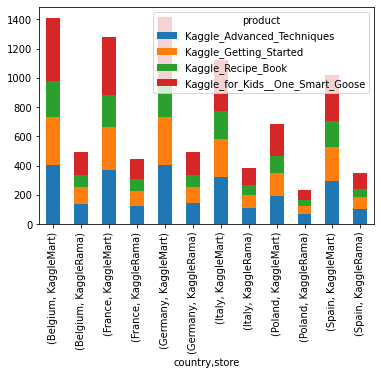

In [10]:
plt.figure(figsize=(15,6))
train_df.groupby(['country','store','product'])['num_sold'].mean().unstack().plot(kind='bar',stacked=True)
plt.show()

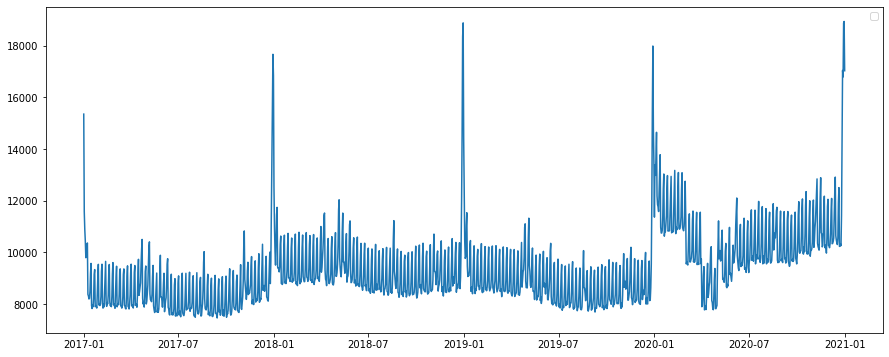

In [11]:
plt.figure(figsize=(15,6))
train_gp = train_df.groupby('date').sum().reset_index()
plt.plot(train_gp['date'], train_gp['num_sold'])
plt.legend()
plt.show()

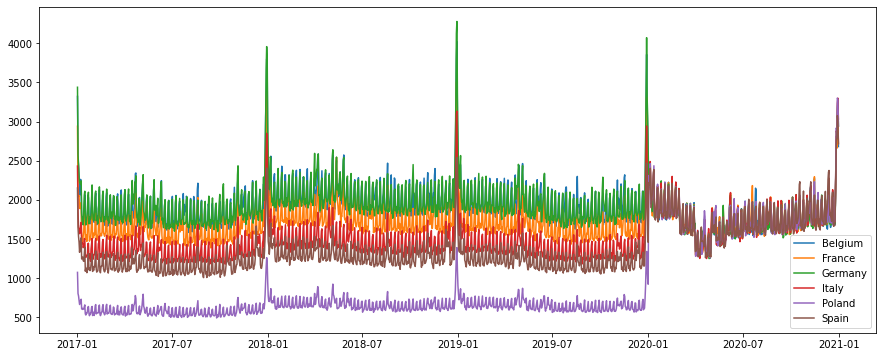

In [12]:
plt.figure(figsize=(15,6))
for country in train_df['country'].unique():
    filt_train = train_df[train_df['country'] == country]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=country)
plt.legend()
plt.show()

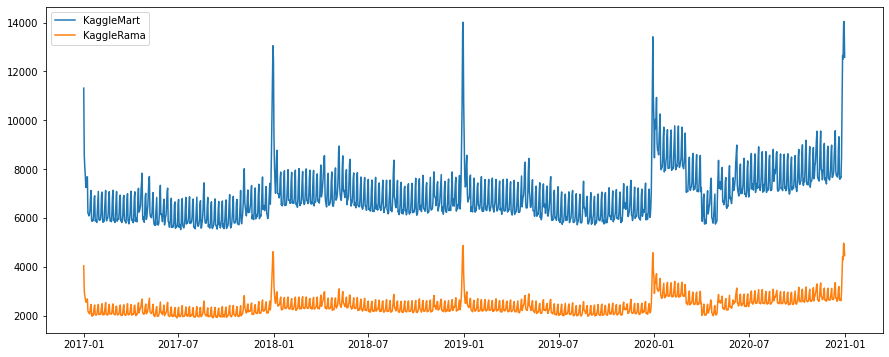

In [13]:
plt.figure(figsize=(15,6))
for store in train_df['store'].unique():
    filt_train = train_df[train_df['store'] == store]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=store)
plt.legend()
plt.show()

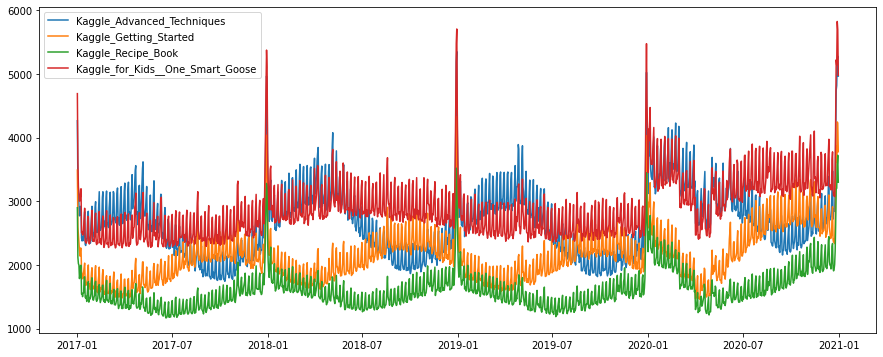

In [14]:
plt.figure(figsize=(15,6))
for product in train_df['product'].unique():
    filt_train = train_df[train_df['product'] == product]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=product)
plt.legend()
plt.show()

In [15]:
weekly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

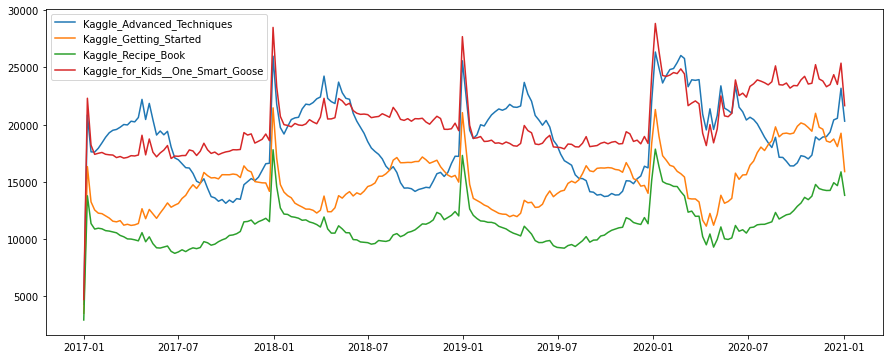

In [16]:
plt.figure(figsize=(15,6))
for product in train_df['product'].unique():
    filt_train = weekly_df[weekly_df['product'] == product]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=product)
plt.legend()
plt.show()

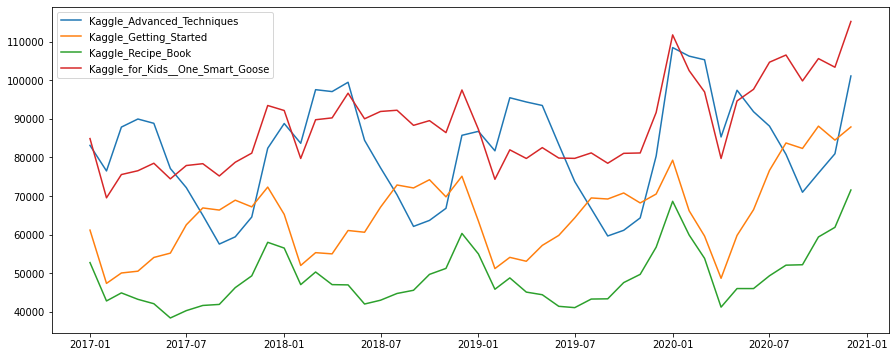

In [17]:
plt.figure(figsize=(15,6))
for product in train_df['product'].unique():
    filt_train = monthly_df[monthly_df['product'] == product]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=product)
plt.legend()
plt.show()

In [18]:
product_store_weights = monthly_df.groupby(["product","store"])["num_sold"].sum() / monthly_df.groupby(["product"])["num_sold"].sum()
product_store_weights

product                           store     
Kaggle_Advanced_Techniques        KaggleMart    0.742447
                                  KaggleRama    0.257553
Kaggle_Getting_Started            KaggleMart    0.742500
                                  KaggleRama    0.257500
Kaggle_Recipe_Book                KaggleMart    0.742765
                                  KaggleRama    0.257235
Kaggle_for_Kids__One_Smart_Goose  KaggleMart    0.742450
                                  KaggleRama    0.257550
Name: num_sold, dtype: float64

In [19]:
store_weights = train_df.groupby("store")["num_sold"].sum()/train_df["num_sold"].sum()
store_weights

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64

In [20]:
new_monthly_df = monthly_df.loc[monthly_df["date"] < "2020-01-01"]
product_country_weights = new_monthly_df.groupby(["product","country"])["num_sold"].sum() / new_monthly_df.groupby(["product"])["num_sold"].sum()
product_country_weights

product                           country
Kaggle_Advanced_Techniques        Belgium    0.218832
                                  France     0.191456
                                  Germany    0.219423
                                  Italy      0.159464
                                  Poland     0.071352
                                  Spain      0.139474
Kaggle_Getting_Started            Belgium    0.219094
                                  France     0.191188
                                  Germany    0.219410
                                  Italy      0.159473
                                  Poland     0.071316
                                  Spain      0.139518
Kaggle_Recipe_Book                Belgium    0.219069
                                  France     0.191101
                                  Germany    0.219778
                                  Italy      0.159175
                                  Poland     0.071355
                                  Spain 

In [21]:
(product_country_weights.reset_index().groupby("country")["num_sold"].mean().loc["Belgium"] / product_country_weights.reset_index().groupby("country")["num_sold"].mean())

country
Belgium    1.000000
France     1.144428
Germany    0.997088
Italy      1.373899
Poland     3.068876
Spain      1.570512
Name: num_sold, dtype: float64

In [22]:
product_df = train_df.groupby(["date","product"])["num_sold"].sum().reset_index()
product_df.head()

,date,product,num_sold
0,2017-01-01,Kaggle_Advanced_Techniques,4267
1,2017-01-01,Kaggle_Getting_Started,3492
2,2017-01-01,Kaggle_Recipe_Book,2900
3,2017-01-01,Kaggle_for_Kids__One_Smart_Goose,4693
4,2017-01-02,Kaggle_Advanced_Techniques,3242


In [23]:
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()
product_ratio_df.head(4)

,date,product,ratios
0,2017-01-01,Kaggle_Advanced_Techniques,0.277944
1,2017-01-01,Kaggle_Getting_Started,0.227462
2,2017-01-01,Kaggle_Recipe_Book,0.188900
3,2017-01-01,Kaggle_for_Kids__One_Smart_Goose,0.305693


In [24]:
# product ratio 관련 예측 코드 추가해보기

In [25]:
product_ratio_df.tail()

,date,product,ratios
5839,2020-12-30,Kaggle_for_Kids__One_Smart_Goose,0.300929
5840,2020-12-31,Kaggle_Advanced_Techniques,0.291703
5841,2020-12-31,Kaggle_Getting_Started,0.221948
5842,2020-12-31,Kaggle_Recipe_Book,0.193823
5843,2020-12-31,Kaggle_for_Kids__One_Smart_Goose,0.292525


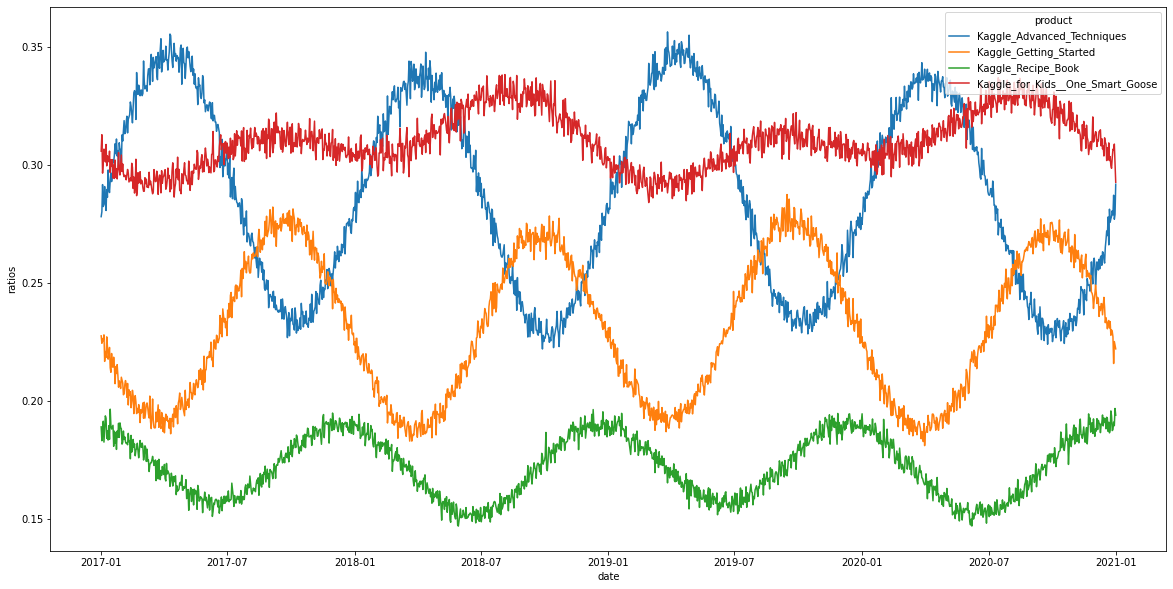

In [26]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = product_ratio_df, x="date", y="ratios", hue="product");

# Train and Aggregated Dataset

In [27]:
train_df = train_df.groupby(["date"])["num_sold"].sum().reset_index()

In [28]:
weekly_df = train_df.groupby([pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train_df.groupby([pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

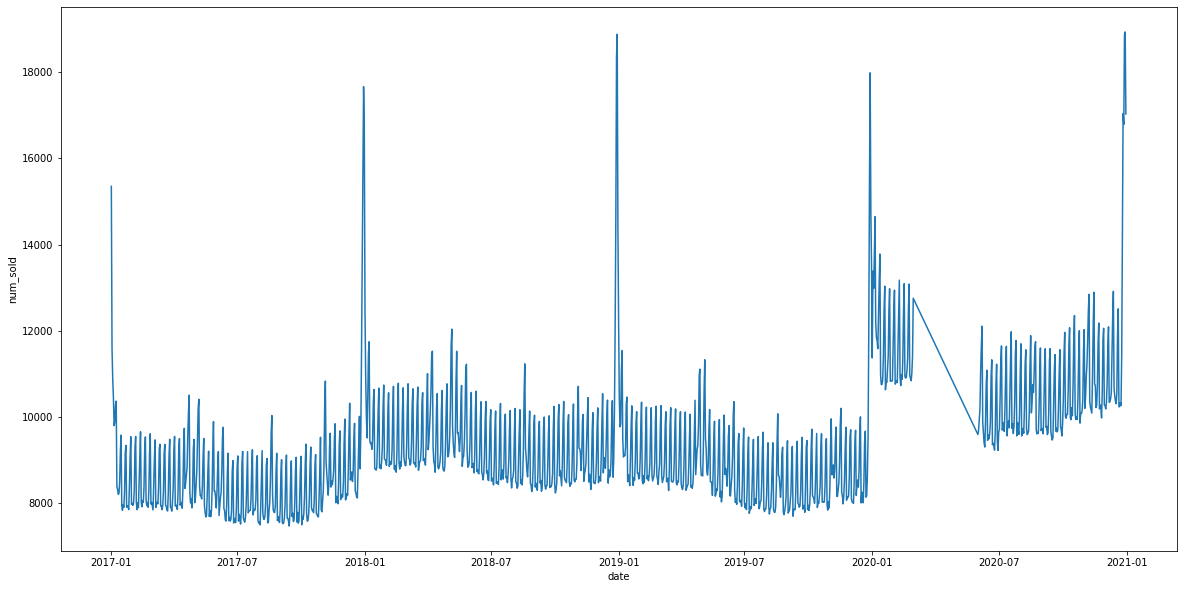

In [29]:
train_nocovid_df = train_df.loc[~((train_df["date"] >= "2020-03-01") & (train_df["date"] < "2020-06-01"))]
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_nocovid_df, x="date", y="num_sold");

In [30]:
train_df = train_nocovid_df

#get the dates to forecast for
test_all_df = test_df.groupby(["date"])["row_id"].first().reset_index().drop(columns="row_id")
#keep dates for later
test_all_df_dates = test_all_df[["date"]]

In [31]:
# https://www.kaggle.com/competitions/optiver-realized-volatility-prediction/discussion/278588

In [32]:
def feature_engineer(df):
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * np.pi / 24)
    new_df["month_cos"] = np.cos(new_df['month'] * np.pi / 24)
    
    new_df["day"] = df["date"].dt.day
    #new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 12))
    new_df["day_sin"] = np.sin(new_df['day'] * np.pi / 62)
    
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    new_df['friday'] = new_df.date.dt.weekday.eq(4).astype(np.uint8)
    new_df['saturday'] = new_df.date.dt.weekday.eq(5).astype(np.uint8)
    new_df['sunday'] = new_df.date.dt.weekday.eq(6).astype(np.uint8)
    
    new_df["day_of_year"] = df["date"].dt.dayofyear

    new_df["day_of_year"] = new_df.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
    
    important_dates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,16,17, 124, 125, 126, 127, 140, 141,142, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179,
                  180, 181, 203, 230, 231, 232, 233, 234, 282, 289, 290, 307, 308, 309, 310, 311, 312, 313, 317, 318, 319, 320, 360, 361, 362, 363, 364, 365]
    

    new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in important_dates else 0)
    
    new_df["year"] = df["date"].dt.year - 2016
    
    easter_date = new_df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))

    for day in list(range(-5, 5)) + list(range(40, 48)):
        new_df[f'easter_{day}'] = (new_df.date - easter_date).dt.days.eq(day)
        
    for col in new_df.columns :
        if 'easter' in col :
            new_df = pd.get_dummies(new_df, columns = [col], drop_first=True)
            
    for day in range(24, 32):
        new_df[f'Dec_{day}'] = new_df.date.dt.day.eq(day) & new_df.date.dt.month.eq(12)
        
        
    new_df = new_df.drop(columns=["date","month","day", "day_of_year"])
    new_df = pd.get_dummies(new_df, columns = ["important_dates","day_of_week"], drop_first=True)
    
    return new_df

In [33]:
def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021]

    holiday_BE = holidays.CountryHoliday('BE', years = years_list)
    holiday_FR = holidays.CountryHoliday('FR', years = years_list)
    holiday_DE = holidays.CountryHoliday('DE', years = years_list)
    holiday_IT = holidays.CountryHoliday('IT', years = years_list)
    holiday_PL = holidays.CountryHoliday('PL', years = years_list)
    holiday_ES = holidays.CountryHoliday('ES', years = years_list)

    holiday_dict = holiday_BE.copy()
    holiday_dict.update(holiday_FR)
    holiday_dict.update(holiday_DE)
    holiday_dict.update(holiday_IT)
    holiday_dict.update(holiday_PL)
    holiday_dict.update(holiday_ES)

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
    return df

In [34]:
train_all_df = get_holidays(train_df)
test_all_df = get_holidays(test_all_df)

In [35]:
train_all_df = feature_engineer(train_all_df)
test_all_df = feature_engineer(test_all_df)

In [36]:
train_all_df['num_sold'] = np.log(train_all_df['num_sold'])

In [37]:
display(train_all_df.head(2))
display(test_all_df.head(2))

,num_sold,holiday_name,is_holiday,month_sin,month_cos,day_sin,friday,saturday,sunday,year,...,important_dates_320,important_dates_360,important_dates_361,important_dates_362,important_dates_363,important_dates_364,important_dates_365,day_of_week_1,day_of_week_2,day_of_week_3
0,9.639001,Nowy Rok,1,0.130526,0.991445,0.050649,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
1,9.356862,Año nuevo (Trasladado),1,0.130526,0.991445,0.101168,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


,holiday_name,is_holiday,month_sin,month_cos,day_sin,friday,saturday,sunday,year,easter_-5_True,...,important_dates_320,important_dates_360,important_dates_361,important_dates_362,important_dates_363,important_dates_364,important_dates_365,day_of_week_1,day_of_week_2,day_of_week_3
0,Año nuevo,1,0.130526,0.991445,0.050649,1,0,0,5,0,...,0,0,0,0,0,0,0,1,0,0
1,Not Holiday,0,0.130526,0.991445,0.101168,0,1,0,5,0,...,0,0,0,0,0,0,0,0,1,0


# **Modelling**

In [38]:
y = train_all_df["num_sold"]
X = train_all_df.drop(columns=["num_sold",'holiday_name'])
X_test = test_all_df.drop(columns=['holiday_name'])

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)
x_train = np.asarray(x_train).astype('float32')
x_test= np.asarray(x_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test= np.asarray(y_test).astype('float32')

def smape(y_true, y_pred):
    smape = abs(y_true - y_pred) / (abs(y_true) + abs(y_pred))
    smape = smape.mean() * 200
    return smape

# Define SMAPE loss function
def Ksmape(y_true, y_pred):
    denominator = (K.abs(y_true) + K.abs(y_pred))/ 200.0
    diff = K.abs(y_true - y_pred) / denominator
    diff = tf.where(tf.math.is_inf(diff), tf.zeros_like(diff), diff)
    return K.mean(diff)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

## **Ridge** 

In [40]:
ridge_preds = np.zeros(X_test.shape[0])
avg_smape = 0
n=0

kf = GroupKFold(n_splits=4)
ridge_df = pd.DataFrame(columns = ['pred','true'])

for trn_idx, test_idx in kf.split(X, groups=X.year) :
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = y.iloc[trn_idx], y.iloc[test_idx]
    
    ridge_model = Ridge(alpha=0.1, tol=1e-3, max_iter=1000000,random_state=0)
    ridge_model.fit(x_train, y_train)

    y_pred = ridge_model.predict(x_valid)
    avg_smape += smape(y_pred, y_valid)
    temp_df = pd.DataFrame.from_dict(dict(zip(y_valid.index,y_pred)),orient='index',columns=['pred'])
    temp_df['true'] = y_valid
    ridge_df = ridge_df.append(temp_df)


    n = n + 1

    test_pred = ridge_model.predict(X_test)
    pred = pd.Series(test_pred) 

    ridge_preds += pred / kf.n_splits  
    
print(f"smape: {avg_smape/kf.n_splits}")

smape: 1.0221883926028101


In [41]:
ridge_df = ridge_df.sort_index()
ridge_df['smape'] = ridge_df.apply(lambda x : smape(x['true'],x['pred']),axis=1)

ridge_df.head(5)

,pred,true,smape
0,9.434893,9.639001,2.140181
1,9.214532,9.356862,1.532793
2,9.133839,9.295049,1.749532
3,9.089798,9.253879,1.788966
4,9.119532,9.189627,0.765687


<AxesSubplot:>

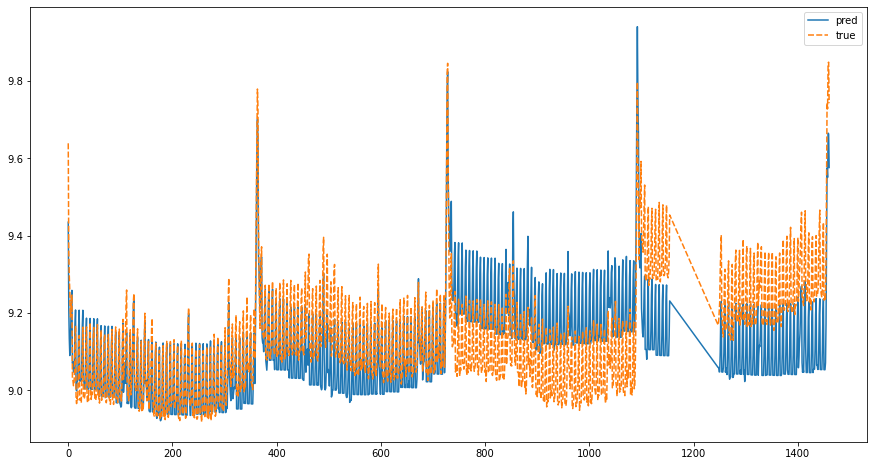

In [42]:
f,ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=ridge_df.drop(columns=["smape"]))

Text(0.5, 1.0, 'Correlations')

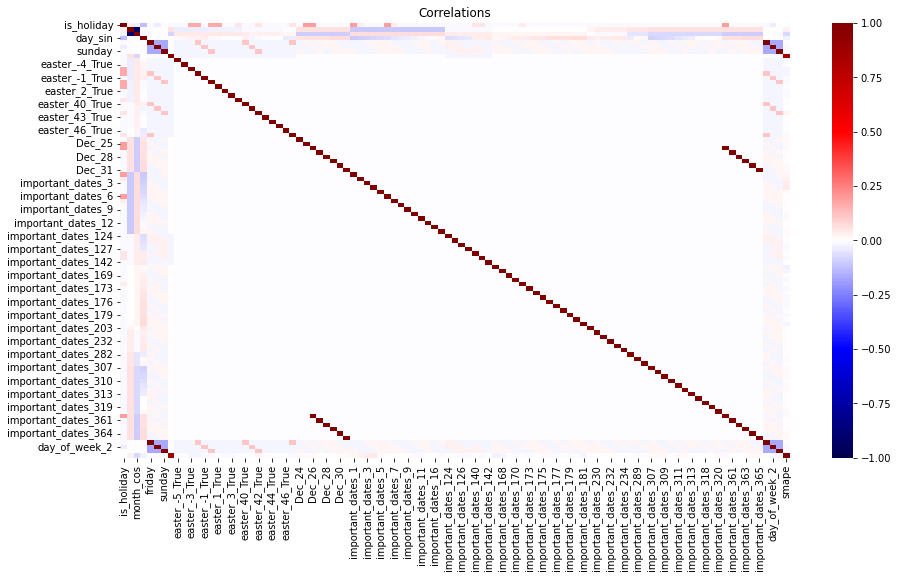

In [43]:
f,ax = plt.subplots(figsize=(15,8))
corr_df = pd.concat([X, ridge_df['smape']], axis=1)
sns.heatmap(corr_df.corr(),cmap="seismic", vmin=-1, vmax=1)
plt.title('Correlations')

<AxesSubplot:xlabel='month_cos', ylabel='smape'>

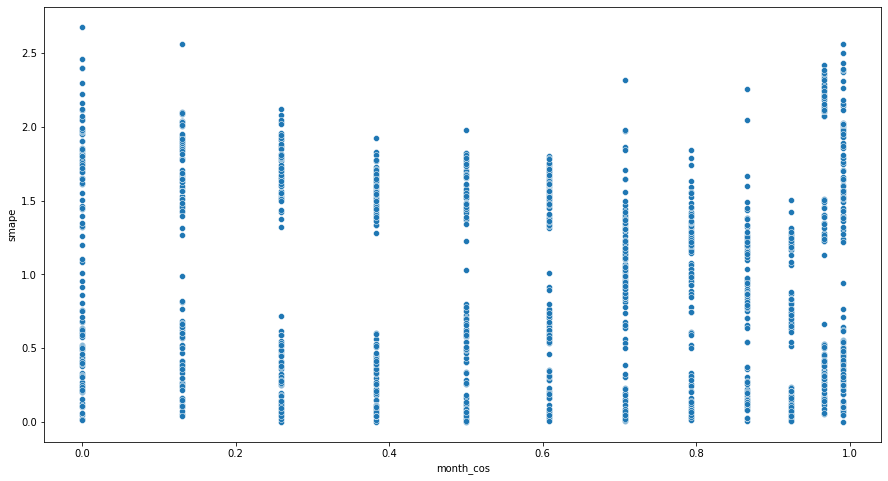

In [44]:
f,ax = plt.subplots(figsize=(15,8))
sns.scatterplot(data=corr_df,x='month_cos',y='smape')

## **Lasso**

In [45]:
lasso_preds = np.zeros(X_test.shape[0])
avg_smape = 0
n=0

kf = GroupKFold(n_splits=4)
lasso_df = pd.DataFrame(columns = ['pred','true'])

for trn_idx, test_idx in kf.split(X, groups=X.year) :
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = y.iloc[trn_idx], y.iloc[test_idx]
    
    lasso_model = Lasso(alpha=0.00001, tol=1e-3, max_iter=1000000,random_state=0)
    lasso_model.fit(x_train, y_train)

    y_pred = lasso_model.predict(x_valid)
    avg_smape += smape(y_pred, y_valid)

    n = n + 1

    test_pred = lasso_model.predict(X_test)
    pred = pd.Series(test_pred) 

    lasso_preds += pred / kf.n_splits  
    
print(f"smape: {avg_smape/kf.n_splits}")

smape: 1.0221502119728765


## **Gradient boosting**

In [46]:
def lgbm_objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2,random_state=42)

        
    param = {'metric': 'mape', 
        'random_state': 48,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02, 0.1, 0.04]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),

    }
    model = lgb.LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    metric = smape(test_y, preds)
    
    return metric

In [47]:
study = optuna.create_study(direction='minimize')
study.optimize(lgbm_objective, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Best_trial=study.best_params   

[I 2022-10-03 16:44:43,788] A new study created in memory with name: no-name-f38dcd0e-f3c3-4f61-8c27-25156c19c2d2
[I 2022-10-03 16:44:43,886] Trial 0 finished with value: 0.9225654697189265 and parameters: {'n_estimators': 160, 'reg_alpha': 0.001612306473428695, 'reg_lambda': 0.00756398360512463, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 283, 'min_child_samples': 194, 'min_data_per_groups': 59}. Best is trial 0 with value: 0.9225654697189265.
[I 2022-10-03 16:44:43,982] Trial 1 finished with value: 0.92723718847751 and parameters: {'n_estimators': 232, 'reg_alpha': 1.3875248407487855, 'reg_lambda': 0.02563639212905146, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 764, 'min_child_samples': 190, 'min_data_per_groups': 11}. Best is trial 0 with value: 0.9225654697189265.
[I 2022-10-03 16:44:44,062] Trial 2 finished with value: 0.8608090680676093 and parameters: {'n_estimators': 980, 

Number of finished trials: 30
Best trial: {'n_estimators': 822, 'reg_alpha': 0.0012872151912612787, 'reg_lambda': 0.0011786176309837562, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.04, 'max_depth': 10, 'num_leaves': 452, 'min_child_samples': 18, 'min_data_per_groups': 100}


In [48]:
lgb_preds = np.zeros(X_test.shape[0])
avg_smape = 0
n=0

kf = GroupKFold(n_splits=4)

Best_trial= {'n_estimators': 391, 'reg_alpha': 0.0010356397081781289, 'reg_lambda': 0.00104105557242766, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.04, 'max_depth': 20, 'num_leaves': 996, 'min_child_samples': 2, 'min_data_per_groups': 53}
Best_trial['random_state'] = 42
Best_trial['metric'] = 'mape'

for trn_idx, test_idx in kf.split(X, groups=X.year) :
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = y.iloc[trn_idx], y.iloc[test_idx]
    
    lgb_reg = LGBMRegressor(**Best_trial)

    lgb_reg.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], early_stopping_rounds=100, verbose=False)
    y_pred = lgb_reg.predict(x_valid)

    avg_smape += smape(y_pred, y_valid)

    n = n + 1

    test_pred = lgb_reg.predict(X_test)
    pred = pd.Series(test_pred) 

    lgb_preds += pred / kf.n_splits  
    
print(f"smape: {avg_smape/kf.n_splits}")

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
smape: 1.1450781427615517


# **Forecasting**

In [49]:
sklearn_models = [ridge_model,lasso_model]

contribs = []
for mod in sklearn_models:
    scores = cross_val_score(mod,X,y,scoring=make_scorer(smape,greater_is_better=False))
    contribs.append(np.mean(scores))
    print(mod,scores, np.mean(scores))

Ridge(alpha=0.1, max_iter=1000000, random_state=0) [-0.27295176 -0.64680944 -0.68454608 -1.39255124 -1.78481949] -0.9563356047595981
Lasso(alpha=1e-05, max_iter=1000000, random_state=0, tol=0.001) [-0.27232204 -0.6465985  -0.6855289  -1.39145663 -1.78474287] -0.9561297875697674


In [50]:
test_all_df_dates["num_sold"] = lasso_preds
test_all_df_dates["num_sold"] = np.exp(test_all_df_dates["num_sold"])

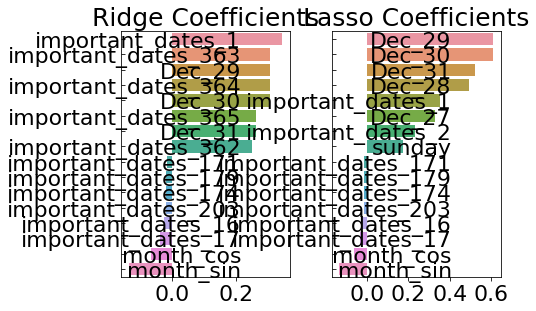

In [51]:
def get_top_bottom_coef(model, n=8):
    coef = pd.Series(model.coef_,index=X.columns)
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

def visualize_coefficient(models):
    fig,axs= plt.subplots(nrows=1,ncols=len(models))
    fig.tight_layout()
    for i_num, model in enumerate(models):
        coef_high,coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high,coef_low])
        axs[i_num].set_title(model.__class__.__name__+' Coefficients',size=25)
        axs[i_num].tick_params(axis='y',direction="in",pad=-120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values,y=coef_concat.index,ax=axs[i_num])
        
visualize_coefficient(sklearn_models)

## Forecasting ratios

In [52]:
product_ratio_2017 = product_ratio_df.loc[product_ratio_df['date'].dt.year == 2017].copy()
product_ratio_2017['mm-dd'] = product_ratio_2017['date'].dt.strftime('%m-%d')
product_ratio_2017 = product_ratio_2017.drop(columns='date')
product_ratio_2017 = product_ratio_2017.reset_index()

product_ratio_2019 = product_ratio_df.loc[product_ratio_df['date'].dt.year == 2019].copy()
product_ratio_2019['mm-dd'] = product_ratio_2019['date'].dt.strftime('%m-%d')
product_ratio_2019 = product_ratio_2019.drop(columns='date')
product_ratio_2019 = product_ratio_2019.reset_index()

#We only use this two years because the period seems to be 2 years

product_ratio_2019['mean_ratios'] = (product_ratio_2017['ratios']+product_ratio_2019['ratios'])/2

In [53]:
product_ratio_2019

,index,product,ratios,mm-dd,mean_ratios
0,2920,Kaggle_Advanced_Techniques,0.279273,01-01,0.278609
1,2921,Kaggle_Getting_Started,0.230832,01-01,0.229147
2,2922,Kaggle_Recipe_Book,0.188119,01-01,0.188510
3,2923,Kaggle_for_Kids__One_Smart_Goose,0.301776,01-01,0.303734
4,2924,Kaggle_Advanced_Techniques,0.281654,01-02,0.280834
...,...,...,...,...,...
1455,4375,Kaggle_for_Kids__One_Smart_Goose,0.304807,12-30,0.304580
1456,4376,Kaggle_Advanced_Techniques,0.277440,12-31,0.279665
1457,4377,Kaggle_Getting_Started,0.224633,12-31,0.224087
1458,4378,Kaggle_Recipe_Book,0.191453,12-31,0.191352


In [54]:
test_product_ratio_df = test_df.copy()
test_product_ratio_df['mm-dd'] = test_product_ratio_df['date'].dt.strftime('%m-%d')

test_product_ratio_df = pd.merge(test_product_ratio_df,product_ratio_2019, how="left", on = ["mm-dd","product"])
test_product_ratio_df.head()

,row_id,date,country,store,product,mm-dd,index,ratios,mean_ratios
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle_Advanced_Techniques,01-01,2920,0.279273,0.278609
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle_Getting_Started,01-01,2921,0.230832,0.229147
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle_Recipe_Book,01-01,2922,0.188119,0.188510
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle_for_Kids__One_Smart_Goose,01-01,2923,0.301776,0.303734
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle_Advanced_Techniques,01-01,2920,0.279273,0.278609


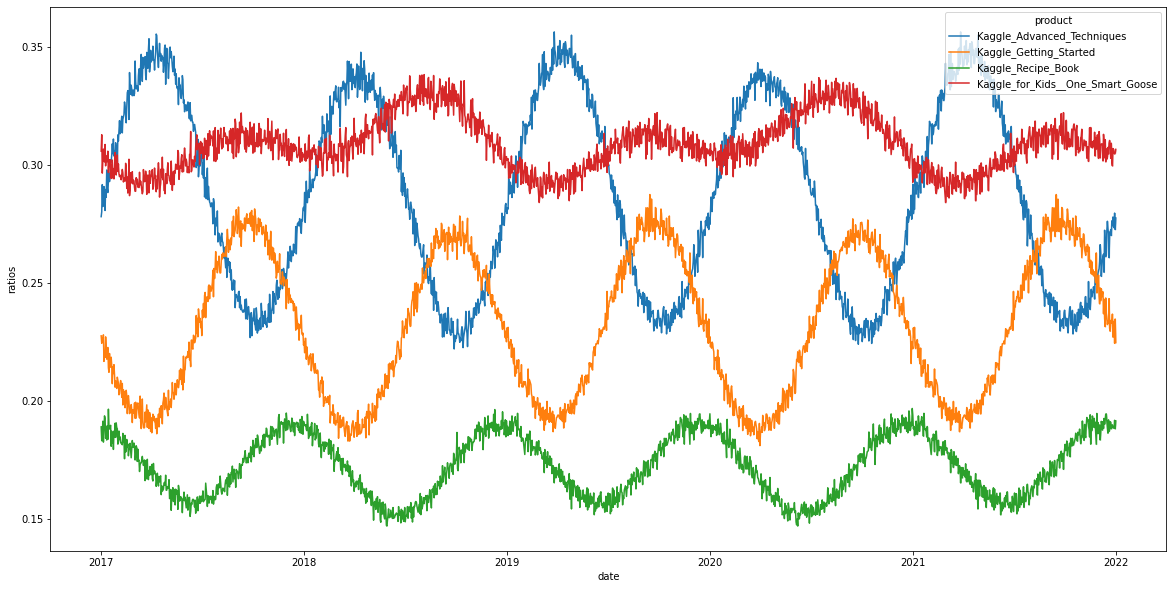

In [55]:
temp_df = pd.concat([product_ratio_df,test_product_ratio_df]).reset_index(drop=True)
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=temp_df, x="date", y="ratios", hue="product");

In [56]:
test_sub_df = pd.merge(test_df, test_all_df_dates, how="left")
test_sub_df["ratios"] = test_product_ratio_df["ratios"]
test_sub_df["mean_ratios"] = test_product_ratio_df["mean_ratios"]
test_sub_df.head()

,row_id,date,country,store,product,num_sold,ratios,mean_ratios
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle_Advanced_Techniques,14775.629624,0.279273,0.278609
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle_Getting_Started,14775.629624,0.230832,0.229147
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle_Recipe_Book,14775.629624,0.188119,0.188510
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle_for_Kids__One_Smart_Goose,14775.629624,0.301776,0.303734
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle_Advanced_Techniques,14775.629624,0.279273,0.278609


In [57]:
df_copy = test_sub_df.copy()

df_copy.head(5)

,row_id,date,country,store,product,num_sold,ratios,mean_ratios
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle_Advanced_Techniques,14775.629624,0.279273,0.278609
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle_Getting_Started,14775.629624,0.230832,0.229147
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle_Recipe_Book,14775.629624,0.188119,0.188510
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle_for_Kids__One_Smart_Goose,14775.629624,0.301776,0.303734
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle_Advanced_Techniques,14775.629624,0.279273,0.278609


In [58]:
for book in df_copy['product'].unique():
  sf = savgol_filter(df_copy[df_copy['product'] == book].mean_ratios, 1001, 3, mode='nearest')
  val_dict = dict(zip(df_copy[df_copy['product'] == book].mean_ratios,sf))
  df_copy[book] = df_copy["mean_ratios"].map(val_dict)

df_copy['smoothed_ratios'] = df_copy['Kaggle_Advanced_Techniques'].combine_first(df_copy['Kaggle_Getting_Started']).combine_first(df_copy['Kaggle_Recipe_Book']).combine_first(df_copy['Kaggle_for_Kids__One_Smart_Goose'])
df_copy = df_copy.drop(columns=df_copy['product'].unique())

df_copy['smoothed_ratios']

0        0.284509
1        0.224658
2        0.188549
3        0.302284
4        0.284509
           ...   
17515    0.305045
17516    0.276570
17517    0.227916
17518    0.190470
17519    0.305045
Name: smoothed_ratios, Length: 17520, dtype: float64

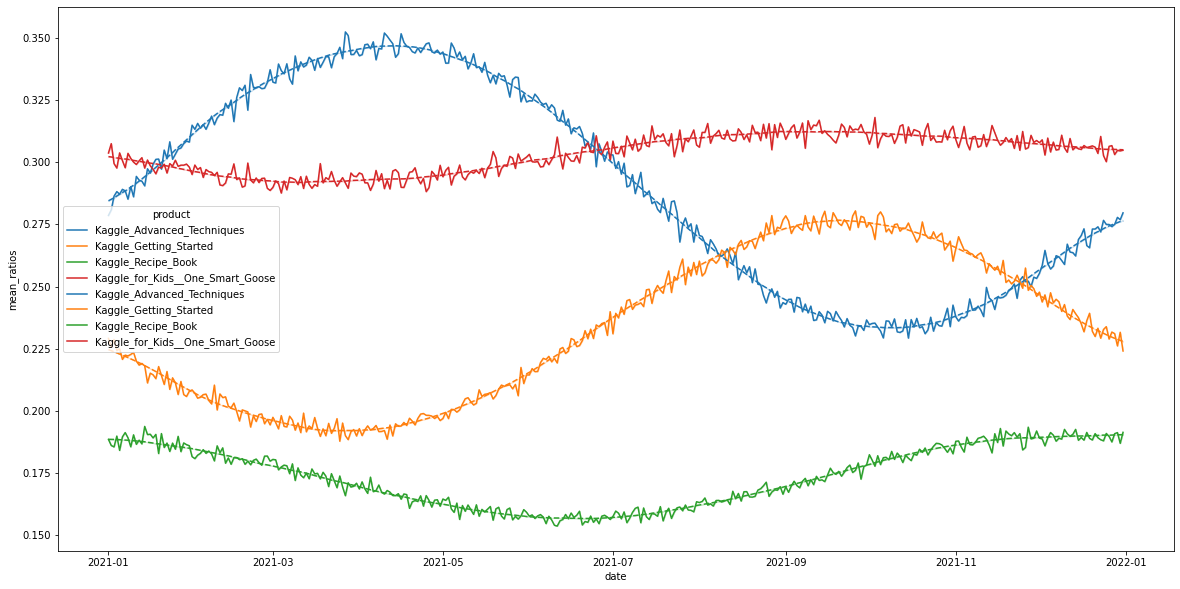

In [59]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=df_copy, x="date", y="mean_ratios", hue="product");
sns.lineplot(data=df_copy, x="date", y="smoothed_ratios", hue="product",linestyle='--');

,row_id,date,country,store,product,num_sold,ratios,mean_ratios,smoothed_ratios
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle_Advanced_Techniques,14775.629624,0.279273,0.278609,0.284509
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle_Getting_Started,14775.629624,0.230832,0.229147,0.224658
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle_Recipe_Book,14775.629624,0.188119,0.188510,0.188549
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle_for_Kids__One_Smart_Goose,14775.629624,0.301776,0.303734,0.302284
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle_Advanced_Techniques,14775.629624,0.279273,0.278609,0.284509


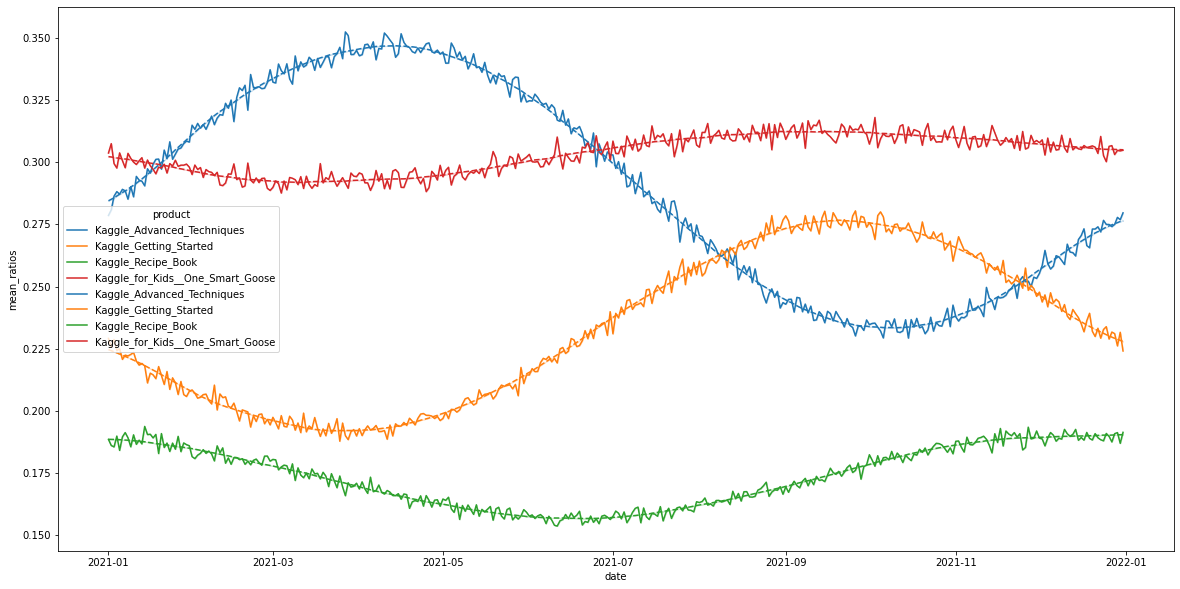

In [60]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=df_copy, x="date", y="mean_ratios", hue="product");
sns.lineplot(data=df_copy, x="date", y="smoothed_ratios", hue="product",linestyle='--');

test_sub_df["smoothed_ratios"] = df_copy["smoothed_ratios"]
test_sub_df.head()

In [61]:
original_train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [62]:
store_weights = original_train_df.groupby('store')['num_sold'].sum()/original_train_df['num_sold'].sum()
store_weights

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64

In [63]:
country_weights = original_train_df.groupby('country')['num_sold'].sum()/original_train_df['num_sold'].sum()
country_weights

country
Belgium    0.204104
France     0.184381
Germany    0.204498
Italy      0.161540
Poland     0.098457
Spain      0.147020
Name: num_sold, dtype: float64

In [64]:
def disaggregate_forecast(df) :
    new_df = df.copy()
    
    store_weights = original_train_df.groupby('store')['num_sold'].sum()/original_train_df['num_sold'].sum()
    print(store_weights)
    country_weights = pd.Series(index = test_sub_df["country"].unique(),data = 1/6)
    print(country_weights)
    for country in country_weights.index:
        new_df.loc[(new_df["country"] == country), "num_sold"] = new_df.loc[(new_df["country"] == country), "num_sold"] *  country_weights[country]
    print(new_df)
    for store in store_weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * store_weights[store]
        
    #new_df["num_sold"] = new_df["num_sold"] * new_df["ratios"]
    #new_df["num_sold"] = new_df["num_sold"] * new_df["mean_ratios"]
    new_df["num_sold"] = new_df["num_sold"] * new_df["smoothed_ratios"]
    new_df["num_sold"] = new_df["num_sold"].round()
    new_df = new_df.drop(columns=["ratios"])    
    
    return new_df

In [65]:
final_df = disaggregate_forecast(test_sub_df)
final_df.head(10)

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64
Belgium    0.166667
France     0.166667
Germany    0.166667
Italy      0.166667
Poland     0.166667
Spain      0.166667
dtype: float64
       row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product     num_sold    ratios  mean_ratios  \
0            Kaggle_Advanced_Techniques  2462.604937  0.279273     0.278609   
1                Kaggle_Getting_Sta

,row_id,date,country,store,product,num_sold,mean_ratios,smoothed_ratios
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle_Advanced_Techniques,520.0,0.278609,0.284509
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle_Getting_Started,411.0,0.229147,0.224658
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle_Recipe_Book,345.0,0.188510,0.188549
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle_for_Kids__One_Smart_Goose,553.0,0.303734,0.302284
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle_Advanced_Techniques,180.0,0.278609,0.284509
5,70133,2021-01-01,Belgium,KaggleRama,Kaggle_Getting_Started,142.0,0.229147,0.224658
6,70134,2021-01-01,Belgium,KaggleRama,Kaggle_Recipe_Book,120.0,0.188510,0.188549
7,70135,2021-01-01,Belgium,KaggleRama,Kaggle_for_Kids__One_Smart_Goose,192.0,0.303734,0.302284
8,70136,2021-01-01,France,KaggleMart,Kaggle_Advanced_Techniques,520.0,0.278609,0.284509
9,70137,2021-01-01,France,KaggleMart,Kaggle_Getting_Started,411.0,0.229147,0.224658


In [66]:
final_df["num_sold"]

0        520.0
1        411.0
2        345.0
3        553.0
4        180.0
         ...  
17515    671.0
17516    211.0
17517    174.0
17518    145.0
17519    233.0
Name: num_sold, Length: 17520, dtype: float64

In [67]:
submission = pd.read_csv("../input/tabular-playground-series-sep-2022/sample_submission.csv")
submission["num_sold"] = final_df["num_sold"]
submission.to_csv('submission.csv', index = False)